# Importing libraries and compiling countours plot from Planck 2018

In [1]:
!pip install lmfit
!pip install corner
!pip install emcee
!pip install numdifftools 
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
!pip install numpy>=1.16.5,<1.23.0
import numpy as np
from numpy import linspace, pi, exp, random, sign, sin, cos
from scipy import optimize
from scipy.optimize import fsolve, root, newton, bisect, ridder, brenth, brentq
import lmfit as lm
from lmfit import Model, minimize, Minimizer, Parameters, report_fit, fit_report
import corner
import emcee
import numdifftools 
from sympy import diff, cos, sin ,simplify, integrate

/bin/bash: 1.23.0: No such file or directory


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


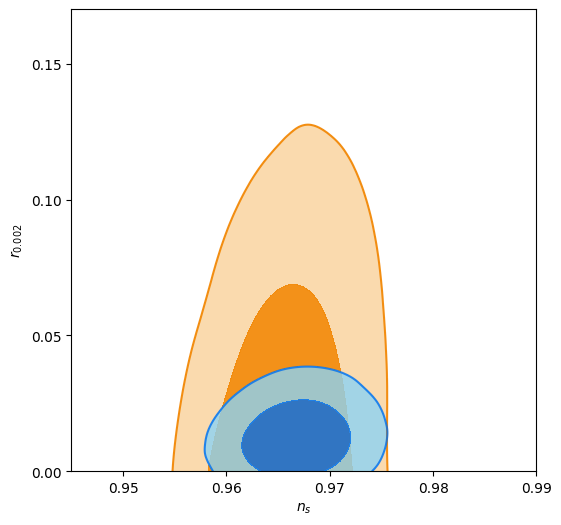

In [2]:
def BICEPKeck_Plot():
    plt.ion()
    plt.figure(figsize=(6,6))

    colors = [('#FAD6A5','#F28500'), ('#8CD3F5', '#006FED')]
    alphas = [0.9, 0.8]
    labels = ['Planck TT,TE,EE+lowE+lensing','+BK18+BAO']

# Load and plot Planck 2018 and BK18 contours
    for i, filename in enumerate(['P18','BK18']):
      xy = np.loadtxt('/kaggle/input/planck-2018-data/'+filename+'density_xy.txt')
      P = np.loadtxt('/kaggle/input/planck-2018-data/'+filename+'density_P.txt')
      levels = np.loadtxt('/kaggle/input/planck-2018-data/'+filename+'density_levels.txt')
      x = xy[:,0]
      y = xy[:,1]
      plt.contourf(x, y, P, levels, colors=colors[i],alpha=alphas[i])
      plt.contour(x, y, P, levels[:1], colors=colors[i][1], alpha=alphas[i])

    plt.ylabel('$r_{0.002}$');    plt.xlabel('$n_s$')
#     plt.legend(labels,frameon=True, labelcolor=[colors[0][1],colors[1][1]])
    plt.ylim(0.00359, 0.170);    plt.xlim(0.945, 0.99)
    plt.gca().set_yticks([0, 0.05, 0.1, 0.15])
    plt.gca().set_xticks([0.95, 0.96, 0.97, 0.98, 0.99])
    
#-------  Legends  --------
Orange = mpatches.Patch(color='#F28500', label='TT,TE,EE+lowE+lensing')
Blue = mpatches.Patch(color='#006FED', label='+BK18+BAO')
Chaotic_Region = mpatches.Patch(color='red',alpha=0.4, label='Chaotic Inflation')
QH_Region = mpatches.Patch(color='#B2BEB5',alpha=0.6, label='Quartic Hilltop model')
NI_Region = mpatches.Patch(color='#98FB98', alpha=0.9, label='Natural Inflation')
QH = mlines.Line2D([], [], color='#B2BEB5', label='Quartic Hilltop', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
Chaotic = mlines.Line2D([], [], color='red', label='Chaotic Inflation $(V\propto\phi^{0.3})$', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
R2 = mlines.Line2D([], [], color='#FFF700', label='Starobinsky $R^2$ Inflation', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
NI = mlines.Line2D([], [], color='#03C03C', label='Natural Inflation ($f=5.4$)', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
Ax_Mon = mlines.Line2D([], [], color='#FF00FF', label='Axion Monodromy', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
MAHI = mlines.Line2D([], [], color='#7FFFD0', label='Axion Hilltop Inflation', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])

N50 = mlines.Line2D([], [], color='k', marker='*', markersize=8, linestyle='None', label='N = 50')
N55 = mlines.Line2D([], [], color='k', marker='*', markersize=10, linestyle='None', label='N = 55')
N60 = mlines.Line2D([], [], color='k', marker='*', markersize=12, linestyle='None', label='N = 60')

BICEPKeck_Plot()

<h1> Chaotic Inflation </h1>
<h2>  Potential  </h2>
<p1>   
\begin{equation}
    V(\phi)=\Lambda^4 \bigg( \frac{\phi}{\mu} \bigg)^q,
\end{equation} 
</p1>

In [10]:
# p=0.500038554330787  # leastsq w/ nsk: χ²=12.2941
# p=0.5                # trust-constr w/ nsk: χ²=12.2937
# p=0.5                # lbfgsb w/ nsk: χ²=12.2937
p=0.30342118396577333  # nelder w/ nsk: χ²=9.2617

##########   F(phi) = epsilon - 1   ##########
def F_CI(x):
    return 0.5*p**2/x**2 - 1

LINm_CI = np.linspace(-7,-0.02,1000);    Rootfinding_Range_Positive_CI = [];    Rootfinding_Range_Negative_CI = []

for i in LINm_CI:
    if F_CI(i)<0:   
        Rootfinding_Range_Negative_CI.append(i)
    elif F_CI(i)>0: 
        Rootfinding_Range_Positive_CI.append(i)    
            
print(len(Rootfinding_Range_Negative_CI), len(Rootfinding_Range_Positive_CI))
Phi_End_CI = ridder(F_CI, Rootfinding_Range_Negative_CI[0], Rootfinding_Range_Positive_CI[0])
print("Phi end value is:",Phi_End_CI)

########   Define N(phi) and use integral method to find upper limit phi_initial   ########
def Integrand_N_CI(x):
    return x/p

def Trapezoidal_N_CI(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
    h = (b - a) / n
    A = Integrand_N_CI(a) + Integrand_N_CI(b)
    i = 1
    while i < n:
        A = A + 2*Integrand_N_CI(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End_CI;     j = 0;      phiI_CI = [];     N_CI = np.linspace(50,60,100)
for n in N_CI:
    while j <= n:
        j = Trapezoidal_N_CI(Phi_End_CI, i, 100)
        i = i + 0.01
    phiI_CI.append(i - 0.01)

##########   Define slow-roll parameters   ##########
def ns_CI(x):    # 1 + 2(eta) - 6(epsilon)
    return 1 + 2*((p**2*x**p/x**2 - p*x**p/x**2)/x**p) - 6*(0.5*p**2/x**2)
    
def r_CI(x):    # 16(epsilon)
    return 16*(0.5*p**2/x**2)
    
nsCI = [];    rCI = [];     nskCI = []

for i in range(len(N_CI)):
    nsCI.append(ns_CI(phiI_CI[i]));        rCI.append(r_CI(phiI_CI[i]))#;        nskCI.append(nsk_CI(phiI_CI[i]))

#     rAM = np.array(rAM);    nsAM = np.array(nsAM);     nskAM = np.array(nskAM)
print("ns[0]=", nsCI[0], "," , "r[0]=", rCI[0])
print("ns[len(nsCI)-1]=", nsCI[len(nsCI)-1], "," ,"r[len(rCI)-1]=" , rCI[len(rCI)-1])

Rmin_CI = [];   NSmin_CI = [];  Rmax_CI = [];   NSmax_CI = []

def Contours_Chaotic_Inflation():    # f = q
    for p in np.arange(0.01,4,0.01):
        
        LINm_CI_c = np.linspace(-10,-0.2,1000);   Rootfinding_Range_Positive_CI_c = [];   Rootfinding_Range_Negative_CI_c = []

        for i in LINm_CI_c:
            if F_CI(i)<0:   
                Rootfinding_Range_Negative_CI_c.append(i)
            elif F_CI(i)>0: 
                Rootfinding_Range_Positive_CI_c.append(i)    
            
#         print(len(Rootfinding_Range_Negative), len(Rootfinding_Range_Positive))
        Phi_End_CI_c = ridder(F_CI, Rootfinding_Range_Negative_CI_c[0], Rootfinding_Range_Positive_CI_c[0])
#         print("Phi end value is:",Phi_End)
        ########   Define N(phi) and use integral method to find upper limit phi_initial   ########
        def Integrand_N_CI_c(x):
            return x/p

        def Trapezoidal_N_CI_c(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
            h = (b - a) / n;       A = Integrand_N_CI_c(a) + Integrand_N_CI_c(b);       i = 1
            while i < n:
                A = A + 2*Integrand_N_CI_c(a + i*h);           i = i+1
            return (h/2)*A

        i = Phi_End_CI_c;     j = 0;      phiI_CI_c = [];     # [50,51,52,53,54,55,56,57,58,59,60]
        for n in N_CI:
            while j <= n:
                j = Trapezoidal_N_CI_c(Phi_End_CI_c, i, 100);            i = i + 0.01
            phiI_CI_c.append(i - 0.01)
            
#         x = np.array(phiI)    
#         ns = 1 + 2*((p**2*x**p/x**2 - p*x**p/x**2)/x**p) - 6*(0.5*p**2/x**2)
        
#         r = 16*(0.5*p**2/x**2)

        #########   Define slow-roll parameters   ##########
        def ns_CI_c(x):    # 1 + 2(eta) - 6(epsilon)
            return 1 + 2*((p**2*x**p/x**2 - p*x**p/x**2)/x**p) - 6*(0.5*p**2/x**2)
    
        def r_CI_c(x):    # 16(epsilon)
            return 16*(0.5*p**2/x**2)
        
        Rmin_CI.append(  r_CI_c(phiI_CI_c[0])  );                 NSmin_CI.append(  ns_CI_c(phiI_CI_c[0])  )
        Rmax_CI.append(  r_CI_c(phiI_CI_c[len(phiI_CI_c)-1]));    NSmax_CI.append(  ns_CI_c(phiI_CI_c[len(phiI_CI_c)-1])  )

    
    for k in range(len(NSmin_CI) - 1):
            plt.plot(NSmin_CI[k:k+2], Rmin_CI[k:k+2], '-', color='red', markersize=1, alpha=0.5)
    for k in range(len(NSmax_CI) - 1):
            plt.plot(NSmax_CI[k:k+2], Rmax_CI[k:k+2], '-', color='red', markersize=1, alpha=0.5)
#     plt.plot(NSmin_CI[:-1], Rmin_CI[:-1], '-', color='red',  markersize=1, alpha=0.5)
#     plt.plot(NSmax_CI[1:], Rmax_CI[1:], '-', color='red',  markersize=1, alpha=0.5)
#     plt.fill_between(NRmax, Rmin, color='red',alpha=0.3)
    plt.fill(np.append(NSmin_CI, NSmax_CI[::-1]), np.append(Rmin_CI, Rmax_CI[::-1]), color='red',alpha=0.2)
#     plt.show()
    
#########   PLOT   #########
# def Chaotic_Inflation():
    plt.plot(nsCI, rCI, '-', color='red', label='$V\propto\phi^{0.3}$', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
    plt.plot(nsCI[0], rCI[0], '*', color='red', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
    plt.plot(nsCI[4], rCI[4], '*', color='red', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
    plt.plot(nsCI[len(nsCI)-1], rCI[len(rCI)-1], '*', color='red', markersize=12, markeredgewidth=0.3, markeredgecolor='black', label='N = 60')
    plt.legend(handles=[Orange, Blue, Chaotic_Region, NI_Region, Chaotic, NI, R2, Ax_Mon, MAHI, N50, N55, N60], 
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
#     plt.legend()

# BICEPKeck_Plot()
# Contours_Chaotic_Inflation()
# Chaotic_Inflation()

972 28
Phi end value is: -0.2145511767369238
ns[0]= 0.977024893307749 , r[0]= 0.02421140909123932
ns[len(nsCI)-1]= 0.9808767299877336 , r[len(rCI)-1]= 0.020152303083117846


<h1> Quartic Hilltop Inflation  </h1>
<h2>  Potential  </h2>
<p1>   
\begin{equation}
    V(\phi)=\Lambda^4 
\end{equation} 
</p1>

In [ ]:
q = 4
m = 30.99
# m = 1.0381627060842165  # leastsq w/ nsk: χ²=2.0884.

##########   F(phi) = epsilon - 1   ##########
def F_HI(x):
    return 0.5*q**2*(x/m)**(2*q)/(x**2*(1 - (x/m)**q)**2) - 1

LINm_HI = np.linspace(0.1,m,1000);    Rootfinding_Range_Positive_HI = [];    Rootfinding_Range_Negative_HI = []

for i in LINm_HI:
    if F_HI(i)<0:   # negative
        Rootfinding_Range_Negative_HI.append(i)
    elif F_HI(i)>0:  # positive
        Rootfinding_Range_Positive_HI.append(i)    
            
# print(len(Rootfinding_Range_Negative_HI), len(Rootfinding_Range_Positive_HI))
Phi_End_HI = ridder(F_HI, Rootfinding_Range_Negative_HI[0], Rootfinding_Range_Positive_HI[0])
# print("Phi end value is:",Phi_End_HI)

########   Define N(phi) and use integral method to find upper limit phi_initial   ########
def Integrand_N_HI(x):
    return -x*(1 - (x/m)**q)/(q*(x/m)**q)

def Trapezoidal_N_HI(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
    h = (b - a) / n
    A = Integrand_N_HI(a) + Integrand_N_HI(b)
    i = 1
    while i < n:
        A = A + 2*Integrand_N_HI(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End_HI;     j = 0;      phiI_HI = [];     N_HI = np.linspace(50,61,100)
for n in N_HI:
    while j <= n:
        j = Trapezoidal_N_HI(Phi_End_HI, i, 100)
        i = i + 0.01
    phiI_HI.append(i - 0.01)

##########   Define slow-roll parameters   ##########
def ns_HI(x):    # 1 + 2(eta) - 6(epsilon)
    return 1 + 2*((-q**2*(x/m)**q/x**2 + q*(x/m)**q/x**2)/(1 - (x/m)**q)) - 6*(0.5*q**2*(x/m)**(2*q)/(x**2*(1 - (x/m)**q)**2))
    
def r_HI(x):    # 16(epsilon)
    return 16*(0.5*q**2*(x/m)**(2*q)/(x**2*(1 - (x/m)**q)**2))
   
    
nsHI = [];    rHI = []#;     nskHI = []

for i in range(len(N_HI)):
    nsHI.append(ns_HI(phiI_HI[i]));        rHI.append(r_HI(phiI_HI[i]))#;        nskHI.append(nsk_HI(phiI[i]))

#     rAM = np.array(rAM);    nsAM = np.array(nsAM);     nskAM = np.array(nskAM)
# print("ns[0]=", nsHI[0], "," , "r[0]=", rHI[0])
# print("ns[len(nsHI)-1]=", nsHI[len(nsHI)-1], "," ,"r[len(rHI)-1]=" , rHI[len(rHI)-1])

Rmin_HI = [];   NSmin_HI = [];  Rmax_HI = [];   NSmax_HI = []

def Contours_Hilltop_Inflation():    # f = q
    for m in np.arange(1,20,0.1):
        
        LINm_HI = np.linspace(0.1,100,100);    Rootfinding_Range_Positive_HI = [];    Rootfinding_Range_Negative_HI = []

        for i in LINm_HI:
            if F_HI(i)<0:   # negative
                Rootfinding_Range_Negative_HI.append(i)
            elif F_HI(i)>0:  # positive
                Rootfinding_Range_Positive_HI.append(i)    
            
        Phi_End_HI = ridder(F_HI, Rootfinding_Range_Negative_HI[0], Rootfinding_Range_Positive_HI[0])
        
        ########   Define N(phi) and use integral method to find upper limit phi_initial   ########
        def Integrand_N_HI(x):
            return -x*(1 - (x/m)**q)/(q*(x/m)**q)

        def Trapezoidal_N_HI(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
            h = (b - a) / n;       A = Integrand_N_HI(a) + Integrand_N_HI(b);       i = 1
            while i < n:
                A = A + 2*Integrand_N_HI(a + i*h);           i = i+1
            return (h/2)*A

        i = Phi_End_HI;     j = 0;      phiI_HI = [];     N_HI = np.arange(50,61,50)
        for n in N_HI:
            while j <= n:
                j = Trapezoidal_N_HI(Phi_End_HI, i, 100);            i = i + 0.01
            phiI_HI.append(i - 0.01)

        #########   Define slow-roll parameters   ##########
        def nsHI_f(x):    # 1 + 2(eta) - 6(epsilon)
            return 1 + 2*((-q**2*(x/m)**q/x**2 + q*(x/m)**q/x**2)/(1 - (x/m)**q)) - 6*(0.5*q**2*(x/m)**(2*q)/(x**2*(1 - (x/m)**q)**2))
    
        def rHI_f(x):    # 16(epsilon)
            return 16*(0.5*q**2*(x/m)**(2*q)/(x**2*(1 - (x/m)**q)**2))
        
        Rmin_HI.append(rHI_f(phiI_HI[0]));    NSmin_HI.append(nsHI_f(phiI_HI[0]))
        Rmax_HI.append(rHI_f(phiI_HI[len(phiI_HI)-1]));    NSmax_HI.append(nsHI_f(phiI_HI[len(phiI_HI)-1]))
    
    plt.plot(NSmin_HI, Rmin_HI, '-', color='red',  linewidth=1.2, alpha=0.8)
    plt.plot(NSmax_HI, Rmax_HI, '-', color='red',  linewidth=1.2, alpha=0.8)
    plt.fill(np.append(NSmin_HI, NSmax_HI[::-1]), np.append(Rmin_HI, Rmax_HI[::-1]), color='red',alpha=0.2)
    plt.show()

#########   PLOT   #########
def Hilltop_Inflation():
    plt.plot(nsHI, rHI, '-', color='#B2BEB5', label='$µ = 1.04$', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
    plt.plot(nsHI[0], rHI[0], '*', color='#B2BEB5', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
    plt.plot(nsHI[51], rHI[51], '*', color='#B2BEB5', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
    plt.plot(nsHI[len(nsHI)-1], rHI[len(rHI)-1], '*', markersize=12, markeredgewidth=0.3, markeredgecolor='black', color='#B2BEB5', label='N = 60')
#     plt.legend()

# BICEPKeck_Plot()
# Hilltop_Inflation()
# Contours_Hilltop_Inflation()
print("Quartic Hilltop Inflation is pending...")

<h1>  $R^2$ Starobinsky Inflation  </h1>
<h2>  Potential  </h2>
<p1>   
\begin{equation}
    V(\phi)=\Lambda^4 \big[ 1-e^{-q\phi} \big]^2.
\end{equation} 
</p1>

915 85
Phi end value is: 0.9401775469999145
ns[0]= 0.9617869079083442 , r[0]= 0.0041462813113660665
ns[len(nsSI)-1]= 0.9680175955132209 , r[len(rSI)-1]= 0.023693112507776063


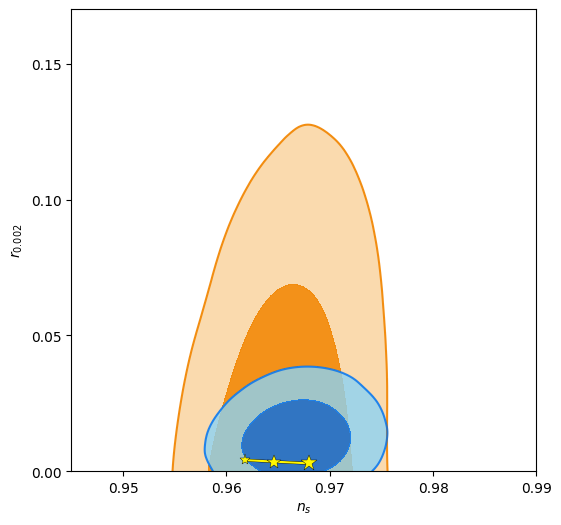

In [4]:
Q = [0.34470931547163824, 0.68]
# q = 0.34470931547163824
q = np.sqrt(2/3)

##########   F(phi) = epsilon - 1   ##########
def F_SI(x):
    return 2.0*q**2*np.exp(-2*q*x)/(1 - np.exp(-q*x))**2 - 1

LINm_SI = np.linspace(0.1,10,1000);    Rootfinding_Range_Positive_SI = [];    Rootfinding_Range_Negative_SI = []

for i in LINm_SI:
    if F_SI(i)<0:   # negative
        Rootfinding_Range_Negative_SI.append(i)
    elif F_SI(i)>0:  # positive
        Rootfinding_Range_Positive_SI.append(i)    
            
print(len(Rootfinding_Range_Negative_SI), len(Rootfinding_Range_Positive_SI))
Phi_End_SI = ridder(F_SI, Rootfinding_Range_Negative_SI[0], Rootfinding_Range_Positive_SI[0])
print("Phi end value is:",Phi_End_SI)

########   Define N(phi) and use integral method to find upper limit phi_initial   ########
def Integrand_N_SI(x):
    return (1 - np.exp(-q*x))*np.exp(q*x)/(2*q)

def Trapezoidal_N_SI(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
    h = (b - a) / n
    A = Integrand_N_SI(a) + Integrand_N_SI(b)
    i = 1
    while i < n:
        A = A + 2*Integrand_N_SI(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End_SI;     j = 0;      phiI_SI = [];     N = [50,51,52,53,54,55,56,57,58,59,60];  NN = np.arange(20,120)
for n in N:
    while j <= n:
        j = Trapezoidal_N_SI(Phi_End_SI, i, 100)
        i = i + 0.01
    phiI_SI.append(i - 0.01)

##########   Define slow-roll parameters   ##########
def ns_SI(x):    # 1 + 2(eta) - 6(epsilon)
    return 1 + 2*((-2*q**2*(1 - np.exp(-q*x))*np.exp(-q*x) + 2*q**2*np.exp(-2*q*x))/(1 - np.exp(-q*x))**2) - 6*(2.0*q**2*np.exp(-2*q*x)/(1 - exp(-q*x))**2)
    
def r_SI(x):    # 16(epsilon)
    return 16*(2.0*q**2*np.exp(-2*q*x)/(1 - np.exp(-q*x))**2)
    
nsSI = [];    rSI = [];     nskSI = [];  RmaxN=[];  NSmaxN=[]
    
for i in range(len(N)):
    nsSI.append(ns_SI(phiI_SI[i]));        rSI.append(r_SI(phiI_SI[i]))#;        nskSI.append(nsk_SI(phiI[i]))
        
# for i in range(len(NN)):
#     NSmaxN.append(ns_SI(phiI[i]));        RmaxN.append(r_SI(phiI[i]))
               
#     rAM = np.array(rAM);    nsAM = np.array(nsAM);     nskAM = np.array(nskAM)
print("ns[0]=", nsSI[0], "," , "r[0]=", rSI[0])
print("ns[len(nsSI)-1]=", nsSI[len(nsSI)-1], "," ,"r[len(rSI)-1]=" , rCI[len(rSI)-1])


# Rmin = [];   NSmin = [];  Rmax = [];   NSmax = []

# def Contours_Starobinsky_Inflation():    # f = q
#     for q in np.arange(0.001,0.68,0.01):
        
#         LINm = np.linspace(0.1,10,1000);    Rootfinding_Range_Positive = [];    Rootfinding_Range_Negative = []

#         for i in LINm:
#             if F_SI(i)<0:   # negative
#                 Rootfinding_Range_Negative.append(i)
#             elif F_SI(i)>0:  # positive
#                 Rootfinding_Range_Positive.append(i)    
            
#         Phi_End = ridder(F_SI, Rootfinding_Range_Negative[0], Rootfinding_Range_Positive[0])
    
#         ########   Define N(phi) and use integral method to find upper limit phi_initial   ########
#         def Integrand_N(x):
#             return (1 - np.exp(-q*x))*np.exp(q*x)/(2*q)

#         def Trapezoidal_N(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
#             h = (b - a) / n;       A = Integrand_N(a) + Integrand_N(b);       i = 1
#             while i < n:
#                 A = A + 2*Integrand_N(a + i*h);           i = i+1
#             return (h/2)*A

#         i = Phi_End;     j = 0;      phiI = [];     N = [50,51,52,53,54,55,56,57,58,59,60]
#         for n in N:
#             while j <= n:
#                 j = Trapezoidal_N(Phi_End, i, 100);            i = i + 0.01
#             phiI.append(i - 0.01)
            
#         #########   Define slow-roll parameters   ##########
#         def ns(x):    # 1 + 2(eta) - 6(epsilon)
#             return 1 + 2*((-2*q**2*(1 - np.exp(-q*x))*np.exp(-q*x) + 2*q**2*np.exp(-2*q*x))/(1 - np.exp(-q*x))**2) - 6*(2.0*q**2*np.exp(-2*q*x)/(1 - exp(-q*x))**2)
    
#         def r(x):    # 16(epsilon)
#             return 16*(2.0*q**2*np.exp(-2*q*x)/(1 - np.exp(-q*x))**2)
        
#         for n in np.arange(30,310,1):
#             RmaxN.append(r(n));    NSmaxN.append(ns(n))
        
#         Rmin.append(r(phiI[0]));    NSmin.append(ns(phiI[0]))
#         Rmax.append(r(phiI[len(phiI)-1]));    NSmax.append(ns(phiI[len(phiI)-1]))
        
    
#     plt.plot(NSmin, Rmin, '-', color='#FFF700',  linewidth=1.5, alpha=0.8)
#     plt.plot(NSmax, Rmax, '-', color='#FFF700',  linewidth=1.5, alpha=0.8)
# #     plt.plot(NSmaxN, RmaxN, '-', color='black',  linewidth=1, alpha=0.8)
#     plt.fill(    np.append(NSmin, NSmax[::-1]), np.append(Rmin, Rmax[::-1]), color='#FFF700',alpha=0.2)
#     plt.show()


########   PLOT   #########
def Starobinsky_Inflation():
    plt.plot(nsSI, rSI, '-', color='#FFF700', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
    plt.plot(nsSI[0], rSI[0], '*', color='#FFF700', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
    plt.plot(nsSI[4], rSI[4], '*', color='#FFF700', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
    plt.plot(nsSI[len(nsSI)-1], rSI[len(rSI)-1], '*', markersize=12, markeredgewidth=0.3, markeredgecolor='black', color='#FFF700', label='N = 60')
#     plt.legend()

BICEPKeck_Plot()
# Contours_Starobinsky_Inflation()
Starobinsky_Inflation()

<h1> Natural Inflation </h1>
<h2>  Potential  </h2>
<p1>   
\begin{equation}
    V(\phi)=\Lambda^4\bigg[ 1-\cos{\bigg( \frac{\phi}{f} \bigg)} \bigg].
\end{equation}
</p1>

Phi end values are: 15.70694427703688


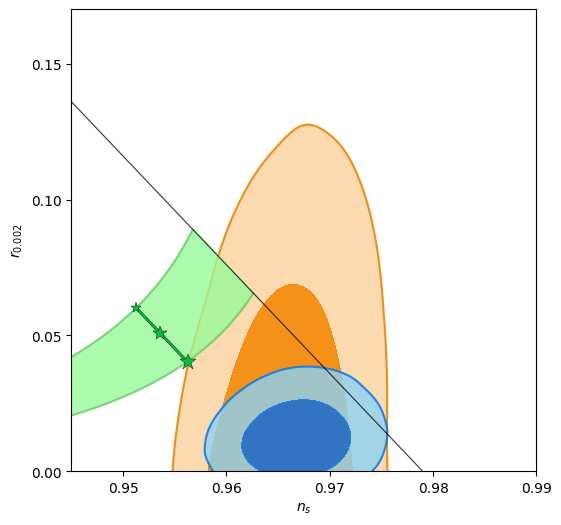

In [5]:
N_NI = np.arange(50,61)
# f = 5.257632106960864   # least_squares: χ²=15.1093
# f = 5.290537142042756   # lbfgsb: χ²=14.9417
f = 5.2139039480952185   # lbfgsb: χ²=15.3548.

# no nsk
f = 5.44733065823633   # lbfgsb: χ²=14.1828.

# ##########   F(phi) = epsilon - 1   ##########
def F_NI(x):
    return -1 + 0.5*np.sin(x/f)**2/(f**2*(np.cos(x/f) + 1)**2)
    
LINm_NI = np.linspace(0,20,1000);   Rootfinding_Range_Positive_NI = [];    Rootfinding_Range_Negative_NI = []

for i in LINm_NI:
    if F_NI(i)<0:   
        Rootfinding_Range_Negative_NI.append(i)
    elif F_NI(i)>0:  
        Rootfinding_Range_Positive_NI.append(i)   
        
Phi_End_NI = ridder(F_NI, Rootfinding_Range_Negative_NI[1], Rootfinding_Range_Positive_NI[1])    
print("Phi end values are:",Phi_End_NI)
 
def Integrand_N_NI(x):
    return -f*(np.cos(x/f) + 1)/np.sin(x/f)

def Trapezoidal_N_NI(a, b, n):
    h = (b - a) / n
    A = Integrand_N_NI(a) + Integrand_N_NI(b)
    i = 1
    while i < n:
        A = A + 2*Integrand_N_NI(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End_NI;    j = 0;      phiI_NI = []
N_array_NI = np.arange(50, 61)
for n in N_array_NI:
    while j <= n:
        j = Trapezoidal_N_NI(Phi_End_NI, i, 100)
        i = i - 0.01
    phiI_NI.append(i + 0.01)

def ns_NI_f(x):
    return 1 + 2*(-np.cos(x/f)/(f**2*(np.cos(x/f) + 1))) - 6*(0.5*np.sin(x/f)**2/(f**2*(np.cos(x/f) + 1)**2))

def r_NI_f(x):
    return 16*(0.5*np.sin(x/f)**2/(f**2*(np.cos(x/f) + 1)**2))

ns_NI = [];     r_NI = []

for i in range(len(N_array_NI)):
    ns_NI.append(ns_NI_f(phiI_NI[i]));    r_NI.append(r_NI_f(phiI_NI[i]))

r_NI = np.array(r_NI);    ns_NI = np.array(ns_NI)


def Contours():    # f = q
    R50_NI = [];   NS50_NI = [];    R60_NI = [];   NS60_NI = [];  Rmax_NI = [];   NSmax_NI = []
    def ns_NI(N, p):
        return 1 - 1/p**2 - 4/ ( (1+2*p**2)*np.exp(N/p**2) - 2*p**2 )
    def r_NI(N, p):
        return 16/( (1+2*p**2)*np.exp(N/p**2) - 2*p**2 )
    
    for n in np.arange(30,310,1):
        Rmax_NI.append(r_NI(n,6.9));    NSmax_NI.append(ns_NI(n,6.9))
        
    for i in np.arange(4,6.9,0.01):
        n_limin_NI = 50;     n_limax_NI = 60
        R50_NI.append(r_NI(n_limin_NI,i));    NS50_NI.append(ns_NI(n_limin_NI,i))
        R60_NI.append(r_NI(n_limax_NI,i));    NS60_NI.append(ns_NI(n_limax_NI,i))

    R50_60_NI = [];   NS50_60_NI = []
    for i in np.arange(4,6.9,0.01):
        for n in N_NI:
            R50_60_NI.append(r_NI(n,i));        NS50_60_NI.append(ns_NI(n,i))
            
    plt.plot(NS50_60_NI, R50_60_NI, '-', color='#98FB98', alpha=0.8)
    plt.plot(NS50_NI, R50_NI, '-', color='#228B22', linewidth=1.5, alpha=0.35 )
    plt.plot(NS60_NI, R60_NI, '-', color='#228B22', linewidth=1.5, alpha=0.35 )
    plt.plot(NSmax_NI, Rmax_NI, '-', color='black',  linewidth=0.8, alpha=0.8)
    custom_lines = [Line2D([0], [0], color='#F28500', lw=4), Line2D([0], [0], color='#006FED', lw=4)]
#     fig, ax = plt.subplots()
#     lines = plt.plot(data)
#     plt.legend(custom_lines, ['Planck TT,TE,EE+lowE+lensing', '+BK18+BAO'])
#     plt.fill_between(R50, NS50, color='#228B22', alpha=0.3)
#     for i in np.arange(0,250,1):
#         plt.plot([NS50[i],NS60[i]], [R50[i],R60[i]],color='#03C03C',alpha=0.3,lw=0.5)
    
#########   PLOT   #########
def Natural_Inflation():
    plt.plot(ns_NI, r_NI, '-', color='#03C03C', label='$f=5.4$', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
    plt.plot(ns_NI[0], r_NI[0], '*', color='#03C03C', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
    plt.plot(ns_NI[4], r_NI[4], '*', color='#03C03C', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
    plt.plot(ns_NI[len(ns_NI)-1], r_NI[len(r_NI)-1], '*', markersize=12, markeredgewidth=0.3, markeredgecolor='black', color='#03C03C', label='N = 60')
#     plt.legend()
    
BICEPKeck_Plot()
Contours()
Natural_Inflation()

<h1> Axion Monodromy Inflation </h1>
<h2>  Potential  </h2>
<p1>   
\begin{equation}
  V(\phi)=\Lambda^4 \left[ \left(\frac{\phi}{\mu}\right)^{p} + b \cos \left( {\frac{\phi}{f}+\theta}\right) \right] .
\end{equation}
</p1>

994 6
Phi end value is: 0.5467913858233417
100 100
n_s last element= 0.9731249654813968 , r last element= 0.0503547487317423


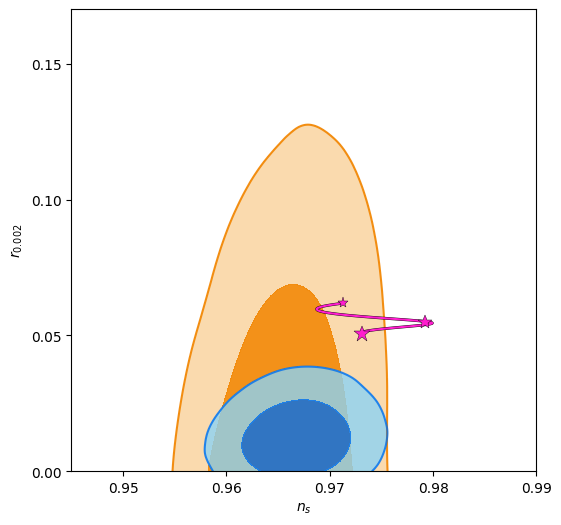

In [6]:
# m = 0.10527847441855696   # leastsq w/ nsk: χ²=17.4975
# p = 0.7720625917556144
# b = 0.001000055630090986
# f = 0.11890636132024514
# t = 6.265804208010714

# m = 0.1051681812148227     # leastsq w/ nsk: χ²=17.4525
# p = 0.7719965152305426
# b = 0.0010002265970380528
# f = 0.11890594368576048
# t = 6.266087231608912

m = 0.10514616016589616     # leastsq w/ nsk: χ²=16.8376
p = 0.7719743890448211
b = 0.0010002379176519728
f = 0.11890591439845422
t = 6.266103045489

# leastsq w/ nsk: χ²=16.481
# m = 0.10000052915823449
# p = 0.7719810853503111
# b = 0.0010025736120588035
# f = 0.11870009337967959
# t = 6.283185307173852

##########   F(phi) = epsilon - 1   ##########
def F(x):
    return -1 + 0.5*(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)**2/(b*np.cos(t + x/f) + (x/m)**p)**2

LINm = np.linspace(0.01,100,1000);    Rootfinding_Range_Positive = [];    Rootfinding_Range_Negative = []

for i in LINm:
    if F(i)<0:   # negative
        Rootfinding_Range_Negative.append(i)
    elif F(i)>0:  # positive
        Rootfinding_Range_Positive.append(i)    
            
#     print(Rootfinding_Range_Negative);    print(Rootfinding_Range_Positive)
print(len(Rootfinding_Range_Negative), len(Rootfinding_Range_Positive))
Phi_End = ridder(F, Rootfinding_Range_Negative[0], Rootfinding_Range_Positive[0])
# Phi_End = fsolve(F,100.0)
# Phi_End = bisect(F,-100,100)
print("Phi end value is:",Phi_End)

########   Define N(phi) and use integral method to find upper limit phi_initial   ########
def Integrand_N(x):
    return (b*np.cos(t + x/f) + (x/m)**p)/(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)

def Trapezoidal_N(a, b, m): 
    h = (b - a) / m
    A = Integrand_N(a) + Integrand_N(b)
    i = 1
    while i < m:
        A = A + 2*Integrand_N(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End;    j = 0;      phiI = []
# N_array = np.arange(50, 61)
N_array = np.linspace(50, 61,100)
for n in N_array:
    while j <= n:
        j = Trapezoidal_N(Phi_End, i, 100)
        i = i+ 0.01
    phiI.append(i-0.01)

##########   Define parameters epsilon & eta   ##########
def ns_AM(x):
    return 1 + 2*((-b*np.cos(t + x/f)/f**2 + p**2*(x/m)**p/x**2 - p*(x/m)**p/x**2)/(b*np.cos(t + x/f) + (x/m)**p)) - 6*(0.5*(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)**2/(b*np.cos(t + x/f) + (x/m)**p)**2)

def r_AM(x):
    return 16*(0.5*(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)**2/(b*np.cos(t + x/f) + (x/m)**p)**2)

nsAM = [];     rAM = []

for i in range(len(N_array)):
    nsAM.append(ns_AM(phiI[i]));    rAM.append(r_AM(phiI[i]))

rAM = np.array(rAM);    nsAM = np.array(nsAM)

print(len(nsAM),len(rAM))
# print(nsAM[0], rAM[0])
print("n_s last element=", nsAM[len(nsAM)-1], ",", "r last element=", rAM[len(rAM)-1])

#########   PLOT   #########
def Axion_Monodromy():
    plt.plot(nsAM, rAM, '-', color='#FF1DCE', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
    plt.plot(nsAM[0], rAM[0], '*', color='#FF1DCE', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
    plt.plot(nsAM[51], rAM[51], '*', color='#FF1DCE', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
    plt.plot(nsAM[len(nsAM)-1], rAM[len(rAM)-1], '*', markersize=12, markeredgewidth=0.3, markeredgecolor='black', color='#FF1DCE', label='N = 60')
#     plt.legend()
    
BICEPKeck_Plot()
Axion_Monodromy()  

# Orange = mpatches.Patch(color='#F28500', label='TT,TE,EE+lowE+lensing')
# Blue = mpatches.Patch(color='#006FED', label='+BK18+BAO')
# Ax_Mon = mlines.Line2D([], [], color='#FF1DCE', label='Axion Monodromy', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])

# N50 = mlines.Line2D([], [], marker='*', markersize=8, markeredgewidth=0.3, linestyle='None', markeredgecolor='black', color='#FF1DCE', label='N = 50')
# N55 = mlines.Line2D([0], [0], marker='*', markersize=10, markeredgewidth=0.3, linestyle='None', markeredgecolor='black', color='#FF1DCE', label='N = 55')
# N60 = mlines.Line2D([], [], marker='*', markersize=12, markeredgewidth=0.3, linestyle='None', markeredgecolor='black', color='#FF1DCE', label='N = 60')

# plt.legend(handles=[N50, N55, N60])
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# plt.tight_layout()
plt.show()

994 6
Phi end value is: 0.5468071385423954
n_s last element= 0.9957160646954294 , r last element= 0.01544193781678851


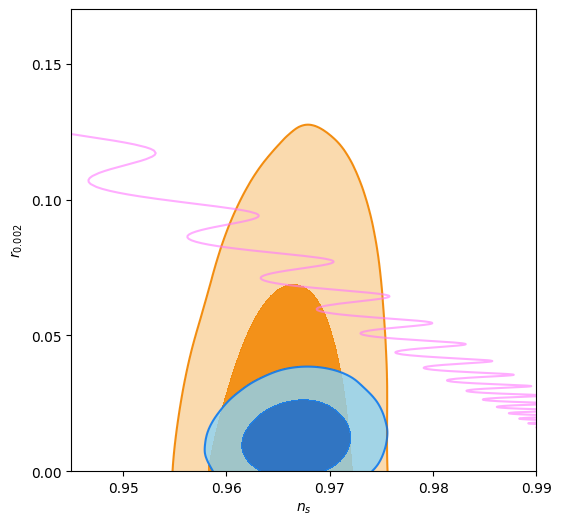

In [7]:
# m = 0.10527847441855696   # leastsq w/ nsk: χ²=17.4975
# p = 0.7720625917556144
# b = 0.001000055630090986
# f = 0.11890636132024514
# t = 6.265804208010714

m = 0.1051681812148227     # leastsq w/ nsk: χ²=17.4525
p = 0.7719965152305426
b = 0.0010002265970380528
f = 0.11890594368576048
t = 6.266087231608912

##########   F(phi) = epsilon - 1   ##########
def F_AM(x):
    return -1 + 0.5*(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)**2/(b*np.cos(t + x/f) + (x/m)**p)**2

LINm_AM = np.linspace(0.01,100,1000);    Rootfinding_Range_Positive_AM = [];    Rootfinding_Range_Negative_AM = []

for i in LINm_AM:
    if F_AM(i)<0:   # negative
        Rootfinding_Range_Negative_AM.append(i)
    elif F_AM(i)>0:  # positive
        Rootfinding_Range_Positive_AM.append(i)    
            
#     print(Rootfinding_Range_Negative);    print(Rootfinding_Range_Positive)
print(len(Rootfinding_Range_Negative_AM), len(Rootfinding_Range_Positive_AM))
Phi_End_AM = ridder(F_AM, Rootfinding_Range_Negative_AM[0], Rootfinding_Range_Positive_AM[0])
# Phi_End = fsolve(F,100.0)
# Phi_End = bisect(F,-100,100)
print("Phi end value is:",Phi_End_AM)

########   Define N(phi) and use integral method to find upper limit phi_initial   ########
def Integrand_N_AM(x):
    return (b*np.cos(t + x/f) + (x/m)**p)/(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)

def Trapezoidal_N_AM(a, b, m): 
    h = (b - a) / m
    A = Integrand_N_AM(a) + Integrand_N_AM(b)
    i = 1
    while i < m:
        A = A + 2*Integrand_N_AM(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End_AM;    j = 0;      phiI_AM = []
N_array_AM = np.linspace(10, 200,1000)
for n in N_array_AM:
    while j <= n:
        j = Trapezoidal_N_AM(Phi_End_AM, i, 100)
        i = i+ 0.01
    phiI_AM.append(i-0.01)

##########   Define parameters epsilon & eta   ##########
def ns_AM(x):
    return 1 + 2*((-b*np.cos(t + x/f)/f**2 + p**2*(x/m)**p/x**2 - p*(x/m)**p/x**2)/(b*np.cos(t + x/f) + (x/m)**p)) - 6*(0.5*(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)**2/(b*np.cos(t + x/f) + (x/m)**p)**2)

def r_AM(x):
    return 16*(0.5*(-b*np.sin(t + x/f)/f + p*(x/m)**p/x)**2/(b*np.cos(t + x/f) + (x/m)**p)**2)

nsAMI = [];     rAMI = []

for i in range(len(N_array_AM)):
    nsAMI.append(ns_AM(phiI_AM[i]));    rAMI.append(r_AM(phiI_AM[i]))

rAMI = np.array(rAMI);    nsAMI = np.array(nsAMI)

# print(nsAM,rAM)
# print(nsAM[0], rAM[0])
print("n_s last element=", nsAMI[len(nsAMI)-1], ",", "r last element=", rAMI[len(rAMI)-1])



#########   PLOT   #########
def Axion_Monodromy_Outline():
    plt.plot(nsAMI, rAMI, '-', color='#FF77FF', linewidth=1.5, alpha=0.6)
#     plt.legend(handles=[Orange, Blue, Chaotic, Quartic, R2, NI, Ax_Mon, N50, N55, N60], bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#     plt.plot(nsAMI[0], rAMI[0], '*', color='#FF00FF', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
#     plt.plot(nsAMI[4], rAMI[4], '*', color='#FF00FF', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
#     plt.plot(nsAMI[len(nsAMI)-1], rAMI[len(rAMI)-1], '*', markersize=12, markeredgewidth=0.3, markeredgecolor='black', color='#FF00FF', label='N = 60')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#     plt.tight_layout()
    

BICEPKeck_Plot()
Axion_Monodromy_Outline() 

<h1>  Minimal Axion Hilltop Inflation </h1>
<h2>  Potential  </h2>
<p1>   
\begin{equation}
    V(\phi)=\Lambda^4 \bigg[ \cos{\bigg( \frac{\phi}{f} + \theta \bigg)} - \frac{\kappa}{n^2}\cos{\bigg( \frac{n\phi}{f} \bigg)} \bigg] + \text{const.},
\end{equation} 
</p1>

In [8]:
# f = 0.1;  t = 0.007;   c = 0     # original
# f = 3.8885946106592115    # para f = 4 inicial con φₑₙ = 5.5 inicial
# t = 0.02499719397081516
# c = 0.04762921597072989

# f = 2.9830321047061408    # para f = 3 inicial con φₑₙ = 4.0 inicial
# t = 0.004493505535293915
# c = -0.01837364381129447

f = 2.9830321047061408
t = 0.004493505535293915
c = -0.01837364381129447

k = 1
n = 3
    

##########   F(phi) = epsilon - 1   ##########
def F_MAHI(x):
    return 0.5*(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)**2/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))**2 - 1

LINm_MAHI = np.linspace(0,6,1000);    Rootfinding_Range_Positive_MAHI = [];    Rootfinding_Range_Negative_MAHI = []

for i in LINm_MAHI:
    if F_MAHI(i)<0:   # negative
        Rootfinding_Range_Negative_MAHI.append(i)
    elif F_MAHI(i)>0:  # positive
        Rootfinding_Range_Positive_MAHI.append(i)    
            
#     print(Rootfinding_Range_Negative);    print(Rootfinding_Range_Positive)
print(len(Rootfinding_Range_Negative_MAHI), len(Rootfinding_Range_Positive_MAHI))
Phi_End_MAHI = ridder(F_MAHI, Rootfinding_Range_Negative_MAHI[0], Rootfinding_Range_Positive_MAHI[0])
# Phi_End = fsolve(F,100.0)
# Phi_End = bisect(F,-100,100)
print("Phi end value is:",Phi_End_MAHI)

########   Define N(phi) and use integral method to find upper limit phi_initial   ########
def Integrand_N_MAHI(x):
    return (c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))/(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)

def Trapezoidal_N_MAHI(a, b, n): ### a is lower limit = phi_end, while b is upper limit = phi_initial ###
    h = (b - a) / n
    A = Integrand_N_MAHI(a) + Integrand_N_MAHI(b)
    i = 1
    while i < n:
        A = A + 2*Integrand_N_MAHI(a + i*h)
        i = i+1
    return (h/2)*A

i = Phi_End_MAHI;     j = 0;      phiI_MAHI = [];     N = np.linspace(50,60,100)
for n in N:
    while j <= n:
        j = Trapezoidal_N_MAHI(Phi_End_MAHI, i, 100)
        i = i - 0.01
    phiI_MAHI.append(i + 0.01)

# print(phiI)
##########   Define parameters epsilon & eta   ##########
def ns_MAHI(x):
    return 1 + 2*((k*np.cos(n*x/f)/f**2 - np.cos(t + x/f)/f**2)/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))) - 6*(0.5*(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)**2/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))**2)
    
def r_MAHI(x):
    return 16*(0.5*(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)**2/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))**2)
    
def nsk_MAHI(x):
    return -16*(0.5*(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)**2/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))**2)*((k*np.cos(n*x/f)/f**2 - np.cos(t + x/f)/f**2)/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))) + 24*(0.5*(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)**2/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))**2)**2 + 2*((-k*n*np.sin(n*x/f)/f**3 + np.sin(t + x/f)/f**3)*(k*np.sin(n*x/f)/(f*n) - np.sin(t + x/f)/f)/(c - k*np.cos(n*x/f)/n**2 + np.cos(t + x/f))**2)

nsMAHI = [];    rMAHI = [];     nskMAHI = []

for i in range(len(N)):
    nsMAHI.append(ns_MAHI(phiI_MAHI[i]));        rMAHI.append(r_MAHI(phiI_MAHI[i]));        nskMAHI.append(nsk_MAHI(phiI_MAHI[i]))

#     rAM = np.array(rAM);    nsAM = np.array(nsAM);     nskAM = np.array(nskAM)
print("ns[0]=", nsMAHI[0], "," , "r[0]=", rMAHI[0])
print("ns[len(nsMAHI)-1]=", nsMAHI[len(nsMAHI)-1], "," ,"r[len(rMAHI)-1]=" , rMAHI[len(rMAHI)-1])

#########   PLOT   #########
def Minimal_Axion_Hilltop_Inflation():
#     plt.plot(figsize=(10,6))
    plt.plot(nsMAHI, rMAHI, '-', color='#7FFFD0', path_effects=[patheffects.Stroke(linewidth=2, foreground='black'), patheffects.Normal()])
    plt.plot(nsMAHI[0], rMAHI[0], '*', color='#7FFFD0', markersize=8, markeredgewidth=0.3, markeredgecolor='black', label='N = 50')
    plt.plot(nsMAHI[51], rMAHI[51], '*', color='#7FFFD0', markersize=10, markeredgewidth=0.3, markeredgecolor='black', label='N = 55')
    plt.plot(nsMAHI[len(nsMAHI)-1], rMAHI[len(rMAHI)-1], '*', markersize=12, markeredgewidth=0.3, markeredgecolor='black', color='#7FFFD0', label='N = 60')
    plt.yticks([0, 0.05, 0.10, 0.15, 0.20])
#     plt.xticks([0.95, 0.96, 0.97, 0.98, 0.99, 1.00])
    plt.ylim(-0.001, 0.150)
    plt.xlim(0.94, 0.99)
    plt.legend()
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#     plt.tight_layout()
    
# BICEPKeck_Plot()
# Minimal_Axion_Hilltop_Inflation()

776 224
Phi end value is: 3.9663224592533672
ns[0]= 0.9415656780406259 , r[0]= 2.873182031387321e-05
ns[len(nsMAHI)-1]= 0.9877710848063482 , r[len(rMAHI)-1]= 1.9678561325938788e-05


# Predictions on the $n_s-r$ plane

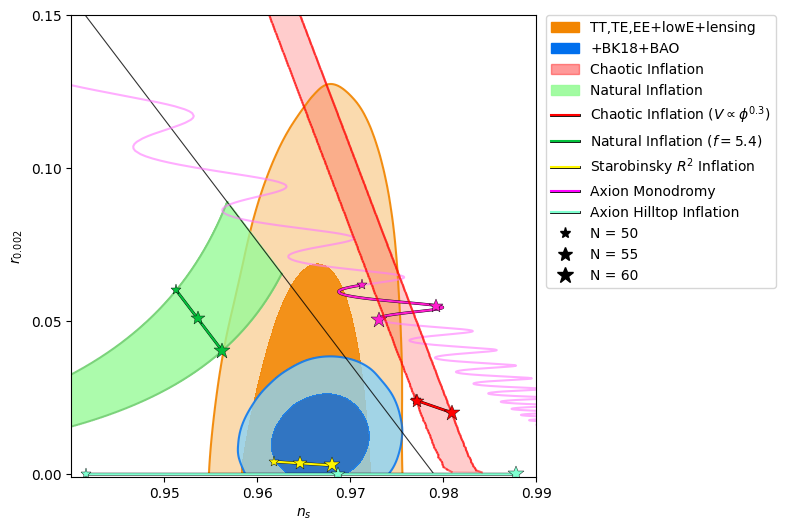

<Figure size 3500x1500 with 0 Axes>

In [11]:
BICEPKeck_Plot()

Contours()
Natural_Inflation()

Axion_Monodromy_Outline()
Axion_Monodromy() 

Minimal_Axion_Hilltop_Inflation()
Starobinsky_Inflation()

Contours_Chaotic_Inflation()
# Chaotic_Inflation()

plt.figure(figsize=(35, 15)) 
plt.tight_layout()
plt.show()